# Project Part II: Predicting Housing Prices - Build Your Own Model

 

### Grading Scheme

Your grade for the project will be based on your training RMSE and test RMSE. The thresholds are as follows:

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Training RMSE | Less than 60k | [60k, 120k) | [120k, 200k) | More than 230k

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Test RMSE | Less than 65k | [65k, 130k) | [130k, 230k) | More than 230k

The top 20% of the submissions with the least testing errors will receive the additional two points


In [1]:
# Some Imports You Might Need
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as lm

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# Extract Dataset
with zipfile.ZipFile('cook_county_contest_data.zip') as item:
    item.extractall()
    
    
### Note: we filtered the data in cook_county_contest_data, 
####so please use this dataset instead of the old one.

### Note

This notebook is specifically designed to guide you through the process of exporting your model's predictions on the test dataset for submission so you can see how your model performs.

Most of what you have done in project part I should be transferrable here. 

## Step 1. Set up all the helper functions for your `process_data_fm` function.

**Copy-paste all of the helper functions your `process_data_fm` need here in the following cell**. You **do not** have to fill out all of the functions in the cell below -- only fill out those that are actually useful to your feature engineering pipeline.

In [17]:
def add_total_bedrooms(data):
    with_rooms = data.copy()
    with_rooms["Bedrooms"] = with_rooms["Description"].str.findall(".*(\d+) of which are bedrooms.*").str[0].astype(int)
    with_rooms["Rooms"] = with_rooms["Description"].str.findall(".*(\d+) rooms.*").str[0].astype(int)
    with_rooms["Bathrooms"] = with_rooms["Description"].str.findall(".*(\d+) of which are bathrooms.*").str[0].astype(int)
    return with_rooms

def ohe_roof_material(data):
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[["Roof Material"]])
    ohe_cols = pd.DataFrame(oh_enc.transform(data[["Roof Material"]]).todense(), 
                           columns = oh_enc.get_feature_names(),
                           index = data.index)
    return data.join(ohe_cols)
    
def ohe_wall_material(data):
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[["Wall Material"]])
    ohe_cols = pd.DataFrame(oh_enc.transform(data[["Wall Material"]]).todense(), 
                           columns = oh_enc.get_feature_names(),
                           index = data.index)
    return data.join(ohe_cols)

def process_data_gm(data, pipeline_functions):
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data

def select_columns(data, *columns):
    return data.loc[:, columns]

def logTransform(data, column):
    df = data.copy()
    df["Log " + column] = np.log(data[column])
    return df

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

def yearInterval(data):
    data["Sale Year"] = data["Sale Year"] - 2013
    return data

def substitute_roof_material(data):
    data["Roof Material"] = data["Roof Material"].replace({
            1: "Shingle/Asphalt",
            2: "Tar&Gravel",
            3: "Slate",
            4: "Shake",
            5: "Tile",
            6: "Other"})
    return data

def substitute_wall_material(data):
    data["Wall Material"] = data["Wall Material"].replace({
            1: "Wood",
            2: "Masonry",
            3: "Wood&Masonry",
            4: "Stucco"})
    return data

## Step 2. Setup your `process_data_fm` function

**Create your implementation of `process_data_fm` from into the following cell.**

Here are a few additional things **you should check and change to make sure your `process_data_fm` function satisfies**:
- Unlike part 1, we will not be expecting your `process_data_fm` function to return both the design matrix `X` and the observed target vector `y`; your function should now **only return X**.


In [32]:
# train_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of the function below. 
# Note that data will no longer have the column Sale Price in it directly, so plan your feature engineering process around that.
def process_data_fm(data):
    # Replace the following line with your own feature engineering pipeline
    X = process_data_gm(data, [
        [logTransform, ["Building Square Feet"], None],
        [add_total_bedrooms, None, None],
        [substitute_roof_material, None, None],
        [ohe_roof_material, None, None],
        [substitute_wall_material, None, None],
        [ohe_wall_material, None, None],
        [yearInterval, None, None],
        [select_columns, ["Bedrooms", "Log Building Square Feet", "Garage 1 Area", "Age", "Sale Year", 
                          "Sale Month of Year", "Most Recent Sale", "Neighborhood Code",
                         "Town and Neighborhood", "Property Class", "x0_Shingle/Asphalt",
                         "x0_Other", "x0_Stucco", "x0_Wood&Masonry", "x0_Masonry",
                         "Basement", "Basement Finish", "Other Heating", "Central Air", "Fireplaces",
                         "Attic Type", "Attic Finish", "Design Plan", "Cathedral Ceiling",
                         "Garage 1 Size", "Garage 2 Size", "Garage 2 Attachment",
                          "Garage 2 Material", "Apartments",
                         "Garage 2 Area", "Porch", "Multi Code", "Number of Commercial Units",
                          "Multi Property Indicator", "Use", "O'Hare Noise", "Floodplain", "Road Proximity",
                         "Pure Market Filter", "Rooms", "Bathrooms"], None]
    ])
    return X

from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor

def cross_validate_rmse(phi_function, model):
    model = clone(model)
    five_fold = KFold(n_splits = 5, random_state = 100, shuffle = True)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(train_data):
        X_train = phi_function(train_data.iloc[tr_ind, :])
        y_train = train_data['Sale Price'].iloc[tr_ind]
        X_val = phi_function(train_data.iloc[va_ind, :])
        y_val = train_data['Sale Price'].iloc[va_ind]
        model.fit(X_train, y_train)
        rmse_values.append(rmse(y_train, model.predict(X_train)))
        rmse_values.append(rmse(y_val, model.predict(X_val)))
        print(rmse_values)
        
    return rmse_values

# bootstrap_factor = []
# for i in np.arange(0.1, 1.0, 0.1):
#     bootstrap_factor.append(cross_validate_rmse(process_data_fm, RandomForestRegressor(max_samples = i)))

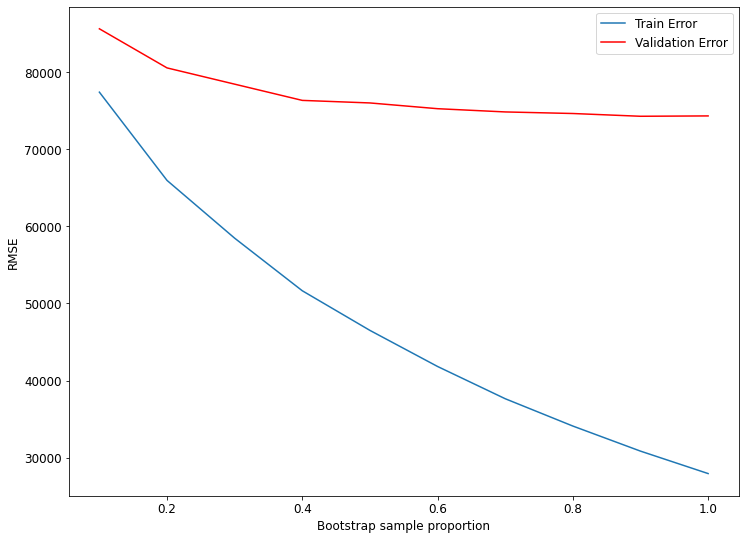

In [39]:
plt.plot(np.arange(0.1, 1.1, 0.1), np.transpose(bootstrap_factor)[0])
plt.plot(np.arange(0.1, 1.1, 0.1), np.transpose(bootstrap_factor)[1], "r")
plt.legend(["Train Error", "Validation Error"])
plt.xlabel("Bootstrap sample proportion")
plt.ylabel("RMSE")
plt.savefig("Bootstrap_factor.png")
plt.show()
# bootstrap_factor

## Step 3. Train your model

Run the following cell to import the new set of training data to fit your model on. **You can use any regression model, the following is just an example** If your `process_data_fm` satisfies all the specified requirements, the cell should run without any error.

**As usual**, your model will predict the log-transformed sale price, and our grading will transform your predictions back to the normal vlaues.

In [14]:
train_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
y_train = train_data['Sale Price']
train_data = train_data.drop(columns=['Sale Price'])
X_train = process_data_fm(train_data)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
###You can use other models
model.fit(X_train, y_train);
y_fitted = model.predict(X_train)
rmse(y_fitted, y_train)


26497.908772352617

## Step 4. Make Predictions on the Test Dataset

Run the following cell to estimate the sale price on the test dataset and export your model's predictions as a csv file called `predictions.csv`.

In [16]:
test_data = pd.read_csv('cook_county_contest_test.csv', index_col='Unnamed: 0')
X_test = process_data_fm(test_data)
y_test_predicted = model.predict(X_test)
predictions = pd.DataFrame({'Sale Price': y_test_predicted})
predictions.to_csv('predictions.csv')
print('Your predictions have been exported as predictions.csv. Please download the file and submit it to Canvas. ')

Your predictions have been exported as predictions.csv. Please download the file and submit it to Canvas. 


## Result

The training result is:

`rmse = 26497.908772352617`

The 5-fold cross validation result is:

    train rmse          test rmse
    26878.01868665509   71207.99700515775
    26866.088698055304  71717.57952440769
    26940.176885743967  72763.35922204204
    26985.02732617549   72064.2820273494
    26861.2185375752    70959.035734583